# Test/Train split with year not working well for the share increase over year

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

In [5]:
plt.style.use('fivethirtyeight')

In [6]:
df = pd.read_csv('day.csv',index_col='dteday', parse_dates=True)

In [7]:
# logarithmic transformation of dependent cols
# (adding 1 first so that 0 values don't become -inf)
for col in ['casual', 'registered', 'cnt']:
    df['%s_log' % col] = np.log(df[col] + 1)

In [8]:
#df['date'] = df.index.date
#df['yr'] = df.index.year
#df['season'] = df.index.quarter
#df['mnth'] = df.index.month
df['day'] = df.index.day
#df['weekday'] = df.index.dayofweek
df['weekofyear'] = df.index.weekofyear



In [9]:
train_slicing = '2011'
test_slicing = '2012'

train = df[train_slicing]
test = df[test_slicing]

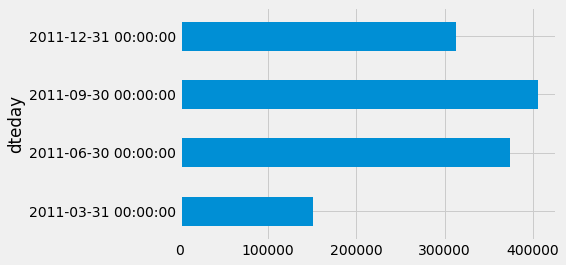

In [10]:
by_season = train['cnt'].resample('Q').sum().plot(kind='barh')

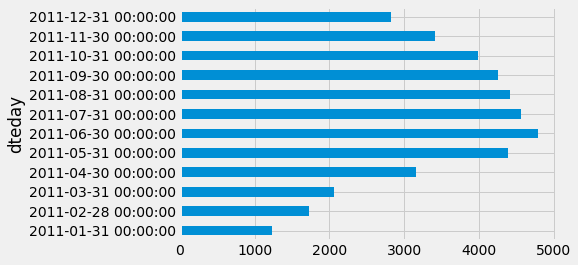

In [11]:
by_month = train['cnt'].resample('M').mean().plot(kind='barh')

In [12]:
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)


def get_data():
    #avoid local variable name and upper leve variable name
    data = train
    return data


def custom_train_test_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    test = data[data['day'] > cutoff_day]
    return train, test

def predict_on_validation_set(model, input_cols):
    #avoid local variable name and upper leve variable name
    data = get_data()

    train, test = custom_train_test_split(data)

    model_r = model.fit(train[input_cols], train['registered_log'])
    y_pred_r = np.exp(model_r.predict(test[input_cols])) - 1

    model_c = model.fit(train[input_cols], train['casual_log'])
    y_pred_c = np.exp(model_c.predict(test[input_cols])) - 1

    y_pred_comb = np.round(y_pred_r + y_pred_c)
    y_pred_comb[y_pred_comb < 0] = 0

    y_test_comb = test['cnt']

    score = get_rmsle(y_pred_comb, y_test_comb)
    return (y_pred_comb, y_test_comb, score)

# predict on test set & transform output back from log scale
def predict_on_test_set(model, x_cols):
    casual_model = model.fit(train[x_cols], train['casual_log'])
    y_pred_cas = casual_model.predict(test[x_cols])
    y_pred_cas = np.exp(y_pred_cas) - 1
    registered_model = model.fit(train[x_cols], train['registered_log'])
    y_pred_reg = registered_model.predict(test[x_cols])
    y_pred_reg = np.exp(y_pred_reg) - 1
    # add casual & registered predictions together
    return y_pred_cas + y_pred_reg

In [13]:
params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_model = RandomForestRegressor(**params)
rf_cols = [
    'weathersit', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 
     'weekday', 'weekofyear'
    #,'peak','sticky','hour',
    ]

(rf_p, rf_t, rf_score) = predict_on_validation_set(rf_model, rf_cols)
print (rf_score)

0.273789399011


In [14]:
df[rf_cols].corr()

,weathersit,temp,atemp,windspeed,workingday,season,holiday,weekday,weekofyear
weathersit,1.000000,-0.120602,-0.121583,0.039511,0.061200,0.019211,-0.034627,0.031087,0.043925
temp,-0.120602,1.000000,0.991702,-0.157944,0.052660,0.334315,-0.028556,-0.000170,0.216432
atemp,-0.121583,0.991702,1.000000,-0.183643,0.052182,0.342876,-0.032507,-0.007537,0.224223
windspeed,0.039511,-0.157944,-0.183643,1.000000,-0.018796,-0.229046,0.006292,0.014282,-0.200993
workingday,0.061200,0.052660,0.052182,-0.018796,1.000000,0.012485,-0.253023,0.035790,-0.015906
season,0.019211,0.334315,0.342876,-0.229046,0.012485,1.000000,-0.010537,-0.003080,0.815417
holiday,-0.034627,-0.028556,-0.032507,0.006292,-0.253023,-0.010537,1.000000,-0.101960,0.020529
weekday,0.031087,-0.000170,-0.007537,0.014282,0.035790,-0.003080,-0.101960,1.000000,0.002315
weekofyear,0.043925,0.216432,0.224223,-0.200993,-0.015906,0.815417,0.020529,0.002315,1.000000


In [15]:
params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls'}
gbm_model = GradientBoostingRegressor(**params)
gbm_cols = [
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
    'holiday', 'workingday', 'season',
     'weekday'
    #, 'ideal', 'count_season','hour','yr'
]

(gbm_p, gbm_t, gbm_score) = predict_on_validation_set(gbm_model, gbm_cols)
print (gbm_score)

0.275060781701


In [16]:
df[gbm_cols].corr()

,weathersit,temp,atemp,hum,windspeed,holiday,workingday,season,weekday
weathersit,1.000000,-0.120602,-0.121583,0.591045,0.039511,-0.034627,0.061200,0.019211,0.031087
temp,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.028556,0.052660,0.334315,-0.000170
atemp,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.032507,0.052182,0.342876,-0.007537
hum,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.015937,0.024327,0.205445,-0.052232
windspeed,0.039511,-0.157944,-0.183643,-0.248489,1.000000,0.006292,-0.018796,-0.229046,0.014282
holiday,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,1.000000,-0.253023,-0.010537,-0.101960
workingday,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.253023,1.000000,0.012485,0.035790
season,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.010537,0.012485,1.000000,-0.003080
weekday,0.031087,-0.000170,-0.007537,-0.052232,0.014282,-0.101960,0.035790,-0.003080,1.000000


In [17]:
# the blend gives a better score on the leaderboard, even though it does not on the validation set
y_p = np.round(.2*rf_p + .8*gbm_p)
print (get_rmsle(y_p, rf_t))

0.265193475235


In [18]:
pd.options.mode.chained_assignment = None
rf_pred = predict_on_test_set(rf_model, rf_cols)
gbm_pred = predict_on_test_set(gbm_model, gbm_cols)
y_pred = np.round(0.2*rf_pred + 0.8*gbm_pred)
# output predictions for submission
test['pred_cnt'] = y_pred
reslut = test[['cnt','pred_cnt']]
#test.to_csv('submit.csv', index=True)

In [19]:
reslut

,cnt,pred_cnt
dteday,,
2012-01-01,2294,1404.0
2012-01-02,1951,1248.0
2012-01-03,2236,1330.0
2012-01-04,2368,1443.0
2012-01-05,3272,1964.0
2012-01-06,4098,2012.0
2012-01-07,4521,2088.0
2012-01-08,3425,2013.0
2012-01-09,2376,1440.0
